# Public Health Safety Initiative - Mask Detection System with TensorFlow
## Business Scenario
In the face of global health challenges like pandemics, wearing masks has proven to be a critical measure in reducing the transmission of airborne diseases. However, ensuring widespread compliance with mask mandates remains a challenge in densely populated areas, public transportation systems, and workplace environments.

Imagine a scenario where a state-of-the-art AI system automatically monitors and identifies individuals not wearing masks in real-time. This technology can enhance public safety measures, streamline enforcement efforts, and contribute to healthier communities. By leveraging advanced machine learning techniques and robust neural networks, this project aims to develop an automated solution for mask detection using computer vision.

This mask detection system can be seamlessly integrated into surveillance systems, helping authorities and organizations enforce safety protocols efficiently. It can be deployed in high-traffic areas like airports, malls, schools, and offices to ensure compliance, minimize health risks, and maintain a safe environment for everyone.

By utilizing transfer learning with powerful pre-trained models and TensorFlow's capabilities, this project seeks to develop a reliable and efficient mask detection system. This AI-powered solution offers significant advantages, including:

- Enhancing public safety: Ensures compliance with mask mandates, reducing the risk of airborne disease transmission.
- Streamlining enforcement efforts: Provides real-time alerts for non-compliance, enabling prompt corrective actions.
- Improving operational efficiency: Reduces the need for manual monitoring, allowing human resources to focus on more critical tasks.

Welcome to the future of public health safety, where technology supports communities in maintaining a healthier and safer environment. Let’s embark on the development of this innovative mask detection system and contribute to a healthier world!

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr

2025-01-26 22:01:57.190844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 22:01:57.276147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 22:01:57.300362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 22:01:57.308166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 22:01:57.390845: I tensorflow/core/platform/cpu_feature_guar

## Loading the train , validation and test sets

In [2]:
# Data directories
train_dir = 'masknet/train'
val_dir = 'masknet/val'
test_dir = 'masknet/test'

## Data Augmentation

In [3]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.4],
    shear_range=0.2,
    channel_shift_range=0.1
)

val_tval_est_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),   
    color_mode='rgb',
    batch_size=32,          
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),   
    color_mode='rgb',
    batch_size=32,           
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),   
    color_mode='rgb',
    batch_size=32,           
    class_mode='binary'
)

Found 164823 images belonging to 2 classes.
Found 5482 images belonging to 2 classes.
Found 5400 images belonging to 2 classes.


###  Visualizing Data Augmentation Effects

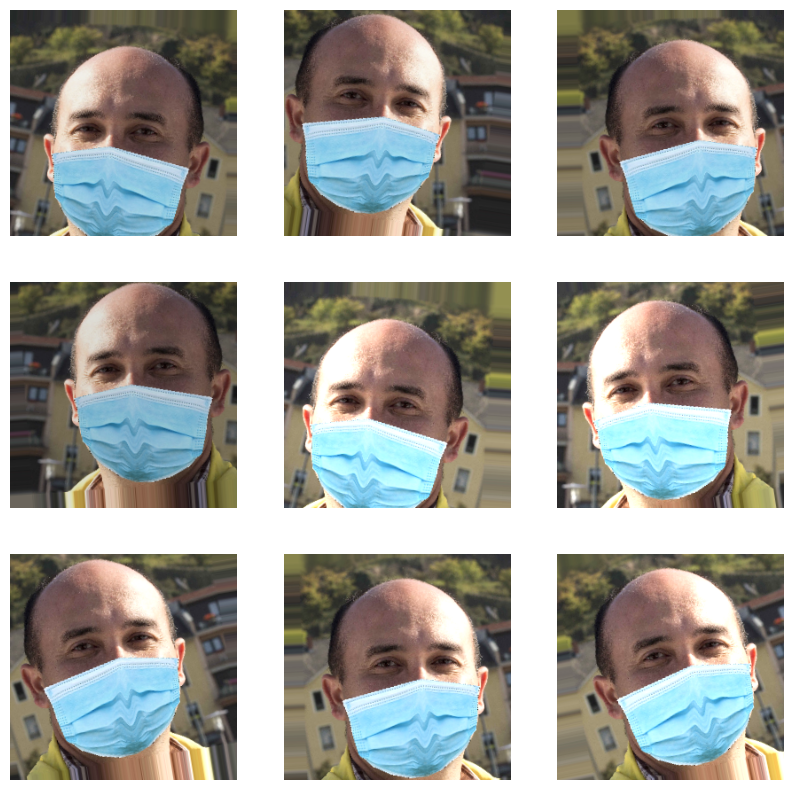

In [4]:
# Get a sample image from your training data
sample_image_path = 'masknet/train/wearing_mask/00045_Mask.jpg'  
img = image.load_img(sample_image_path, target_size=(256, 256), color_mode='rgb')  # Change to RGB
img_array = image.img_to_array(img)  # No need to normalize here

# Expand dimensions to simulate batch size (1)
img_array = np.expand_dims(img_array, axis=0)

# Create an iterator for the augmented images
augmented_images = train_datagen.flow(img_array)  # train_datagen should have rescale=1./255

# Plot a few augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    augmented_image = next(augmented_images)[0]  # Use next() instead of next() method
    plt.imshow(augmented_image)  # Display the image in RGB
    plt.axis('off')
plt.show()

Checking which class is assigned to which binary number

In [5]:
print(train_generator.class_indices)

{'no_mask': 0, 'wearing_mask': 1}


## Defining model architecture

### Loading the Pretrained ResNet50V2 Model

In [5]:
# Load a pre-trained ResNet model
base_model = applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

I0000 00:00:1737921732.708320     548 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737921732.930527     548 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737921732.930596     548 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737921732.933420     548 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737921732.933534     548 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Defining the Input Layer

In [ ]:
input_layer = layers.Input(shape=(256, 256, 3))

### Adding the Custom Classification Layers on Top of ResNet50V2

In [7]:
x = base_model(input_layer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
output_layer = layers.Dense(1, activation='sigmoid')(x)

### Finalizing the Model Architecture

In [8]:
model = models.Model(inputs=input_layer, outputs=output_layer)

### Compiling the Model for Training

In [9]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model with Early Stopping

In [10]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (e.g., val_loss or val_accuracy)
    patience=5,                # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
num_epochs = 40
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    callbacks=[early_stopping],
    verbose=1
)

/home/mamdouh/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1737921853.512853     781 service.cc:146] XLA service 0x7f48700024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737921853.512894     781 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-26 22:04:13.994724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-26 22:04:15.954411: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201
2025-01-26 22:04:18.687607: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19110', 32 bytes spill stores, 32 bytes spill loads

2025-01-26 22:04:18.706928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local mem

3506/5151 ━━━━━━━━━━━━━━━━━━━━ 16:04 587ms/step - accuracy: 0.9744 - loss: 0.0706

2025-01-26 22:39:00.929521: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13817', 176 bytes spill stores, 176 bytes spill loads

2025-01-26 22:39:00.960368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13817', 12 bytes spill stores, 12 bytes spill loads

2025-01-26 22:39:01.070178: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19110', 24 bytes spill stores, 24 bytes spill loads



5151/5151 ━━━━━━━━━━━━━━━━━━━━ 3107s 595ms/step - accuracy: 0.9788 - loss: 0.0594 - val_accuracy: 0.9471 - val_loss: 0.1363
Epoch 2/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 3012s 585ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9466 - val_loss: 0.2283
Epoch 3/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 3042s 591ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.8030 - val_loss: 1.2807
Epoch 4/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 2988s 580ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9393 - val_loss: 0.1661
Epoch 5/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 2992s 581ms/step - accuracy: 0.9976 - loss: 0.0075 - val_accuracy: 0.9661 - val_loss: 0.0965
Epoch 6/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 3023s 587ms/step - accuracy: 0.9981 - loss: 0.0064 - val_accuracy: 0.9115 - val_loss: 0.3353
Epoch 7/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 3033s 589ms/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9473 - val_loss: 0.2167
Epoch 8/40
5151/5151 ━━━━━━━━━━━━━━━━━━━━ 2992s 581ms/step - accur

## Evaluating the Model on the Test Set

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9775 - loss: 0.0676

2025-01-27 15:01:45.539862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1495', 176 bytes spill stores, 176 bytes spill loads

2025-01-27 15:01:45.561509: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1495', 12 bytes spill stores, 12 bytes spill loads



169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9775 - loss: 0.0676
Test Loss: 0.0687, Test Accuracy: 0.9772


## Saving the model for deployment

In [12]:
# Save the trained model
model.save("face_mask_model_new.h5")

## Model Summary

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,390,725 (272.33 MB)

 Trainable params: 23,781,761 (90.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

 Optimizer params: 47,563,524 (181.44 MB)

## Testing the model on real life pics using gradio

However this is not our main target to test on pics , instead our target is real time detection, but let's see how the model will perform on pics first.

In [19]:
import gradio as gr
# Load the trained model
model = tf.keras.models.load_model("face_mask_model_new.h5")

# Define the class labels
class_labels = ["No Mask", "Mask"]

# Define the prediction function
def predict(image):
    # Preprocess the image
    image = image.resize((256, 256))  # Resize to match model's input size
    image_array = np.array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(image_array)
    predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
    
    # Return the predicted class and confidence score
    confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])
    return f"Prediction: {predicted_class} (Confidence: {confidence:.2f})"

# Create Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Face Mask Detection",
    description="Upload an image to check if the person is wearing a face mask."
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/tmp/ipykernel_548/1289742139.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]  # Binary classification
/tmp/ipykernel_548/1289742139.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if predicted_class == "Mask" else 1 - float(prediction[0])
